In [2]:
import os
import json
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm
import wandb

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.manifold import TSNE

os.environ['WANDB_DIR'] = 'wb_logs'
# Set plot style
plt.style.use('ggplot')
sns.set(font_scale=1.2)
sns.set_style("whitegrid")

## 1. Probe Models

We've trained two types of probes:

1. **Linear Probe**: A simple linear layer that predicts linguistic features
2. **Non-linear Probe**: A two-layer neural network with ReLU activation

These probes will be trained to predict:
- Part-of-speech (POS) tags
- Dependency relations

In [3]:
class LinearProbe(nn.Module):
    def __init__(self, input_dim, output_dim):
        super().__init__()
        self.linear = nn.Linear(input_dim, output_dim)

    def forward(self, x):
        return self.linear(x)


class NonlinearProbe(nn.Module):
    def __init__(self, input_dim, output_dim, hidden_dim=128):
        super().__init__()
        self.network = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, output_dim)
        )

    def forward(self, x):
        return self.network(x)


# Define a random baseline probe for comparison
class RandomPredictionProbe(nn.Module):
    def __init__(self, n_classes):
        super().__init__()
        self.n_classes = n_classes

    def forward(self, x):
        return torch.randint(0, self.n_classes, (x.size(0),), device=x.device)

## 2. Evaluation Functions

In [ ]:
def load_embedding_artifacts():
    embedding_artifact_names = {
        "E5": "mech_decomp/mechanistic-decomposition-sentence-embeddings/embeddings-multilingual-e5-large:latest",
        "MPNET": "mech_decomp/mechanistic-decomposition-sentence-embeddings/embeddings-all-mpnet-base-v2:latest",
        "MiniLM": 'mech_decomp/mechanistic-decomposition-sentence-embeddings/embeddings-all-MiniLM-L6-v2:latest',
    }

    embedding_dirs = {}
    for name, artifact_path in embedding_artifact_names.items():
        run = wandb.init(project="mechanistic-decomposition-sentence-embeddings", reinit=True)
        artifact = run.use_artifact(artifact_path, type="embeddings")
        artifact_dir = artifact.download()
        embedding_dirs[name] = artifact_dir
        run.finish()

    return embedding_dirs

# Usage
embedding_dirs = load_embedding_artifacts()
print(embedding_dirs)

In [7]:
import os
import glob
import pandas as pd
import pickle

def load_embeddings_from_dirs(embedding_dirs):
    """
    Loads both CSV and pickle files for each embedding model from their respective artifact directories.
    
    Returns a dict of the form:
    {
        "E5": {"csv": df, "pkl": embeddings},
        "GTE": {"csv": df, "pkl": embeddings},
        ...
    }
    """
    all_embeddings = {}

    for name, dir_path in embedding_dirs.items():
        # Find the CSV file
        csv_files = glob.glob(os.path.join(dir_path, "*.csv"))
        pkl_files = glob.glob(os.path.join(dir_path, "*.pkl"))

        if not csv_files:
            raise FileNotFoundError(f"No CSV file found in {dir_path}")
        if not pkl_files:
            raise FileNotFoundError(f"No pickle file found in {dir_path}")

        csv_path = csv_files[0]
        pkl_path = pkl_files[0]

        df = pd.read_csv(csv_path)
        with open(pkl_path, "rb") as f:
            embeddings = pickle.load(f)

        df['embedding'] = [embeddings[idx] for idx in df['embedding_idx']]

        all_embeddings[name] = {"csv": df, "pkl": embeddings}

    return all_embeddings

embedding_data = load_embeddings_from_dirs(embedding_dirs)

In [34]:
def evaluate_probe(model, X, y):
    """Evaluate a classification probe."""
    model.eval()
    with torch.no_grad():
        if isinstance(model, RandomPredictionProbe):
            preds = model(X)
        else:
            preds = model(X).argmax(dim=1)
        accuracy = (preds == y).float().mean().item()
    return accuracy

def train_probe(model, X, y, task_name="TASK", epochs=10, output_dir="trained_models"):
    """Train a classification probe."""
    model.train()
    loss_fn = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=1e-3)
    dataset = TensorDataset(X, y)
    loader = DataLoader(dataset, batch_size=64, shuffle=True)

    for epoch in range(epochs):
        total_loss = 0
        for xb, yb in tqdm(loader, desc=f"{task_name} Epoch {epoch+1}"):
            optimizer.zero_grad()
            logits = model(xb)
            loss = loss_fn(logits, yb)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        print(f"{task_name} - Epoch {epoch+1}, Loss: {total_loss:.4f}")
    return model

def run_all_probes_and_controls(X, y_pos, y_dep, le_pos, le_dep, hidden_dim=128):
    """Run all probes and control experiments."""
    results = {}

    # === Main Probes ===
    print("\n=== Training Main Probes ===")
    pos_model = train_probe(LinearProbe(X.shape[1], len(le_pos.classes_)), X, y_pos, "POS")
    dep_model = train_probe(LinearProbe(X.shape[1], len(le_dep.classes_)), X, y_dep, "DEP")

    # === Nonlinear Probes ===
    print("\n=== Training Nonlinear Probes ===")
    pos_nonlinear = train_probe(NonlinearProbe(X.shape[1], len(le_pos.classes_), hidden_dim=hidden_dim), X, y_pos, "POS_Nonlinear")
    dep_nonlinear = train_probe(NonlinearProbe(X.shape[1], len(le_dep.classes_), hidden_dim=hidden_dim), X, y_dep, "DEP_Nonlinear")

    # === Random Baselines ===
    print("\n=== Evaluating Random Baselines ===")
    pos_random = RandomPredictionProbe(len(le_pos.classes_))
    dep_random = RandomPredictionProbe(len(le_dep.classes_))

    # === Shuffled Labels ===
    print("\n=== Training with Shuffled Labels ===")
    pos_shuffled = train_probe(LinearProbe(X.shape[1], len(le_pos.classes_)), X, y_pos[torch.randperm(len(y_pos))], "POS_Shuffled")
    dep_shuffled = train_probe(LinearProbe(X.shape[1], len(le_dep.classes_)), X, y_dep[torch.randperm(len(y_dep))], "DEP_Shuffled")

    # === Random Representations ===
    print("\n=== Training with Random Representations ===")
    X_rand = torch.randn_like(X)
    pos_randrep = train_probe(LinearProbe(X.shape[1], len(le_pos.classes_)), X_rand, y_pos, "POS_RandomRep")
    dep_randrep = train_probe(LinearProbe(X.shape[1], len(le_dep.classes_)), X_rand, y_dep, "DEP_RandomRep")

    # === Evaluation ===
    print("\n=== Evaluation ===")
    results = {
        "POS": {
            "linear": evaluate_probe(pos_model, X, y_pos),
            "nonlinear": evaluate_probe(pos_nonlinear, X, y_pos),
            "random": evaluate_probe(pos_random, X, y_pos),
            "shuffled": evaluate_probe(pos_shuffled, X, y_pos),
            "random_rep": evaluate_probe(pos_randrep, X, y_pos)
        },
        "DEP": {
            "linear": evaluate_probe(dep_model, X, y_dep),
            "nonlinear": evaluate_probe(dep_nonlinear, X, y_dep),
            "random": evaluate_probe(dep_random, X, y_dep),
            "shuffled": evaluate_probe(dep_shuffled, X, y_dep),
            "random_rep": evaluate_probe(dep_randrep, X, y_dep)
        }
    }
    return results

In [40]:
from sklearn.preprocessing import LabelEncoder

def get_data_for_model(model_name):
    df = embedding_data[model_name]['csv']
    X = torch.stack(df['embedding'].tolist())
    
    le_pos = LabelEncoder().fit(df["pos"])
    le_dep = LabelEncoder().fit(df["dep"])
    
    y_pos = torch.tensor(le_pos.transform(df['pos'].values))
    y_dep = torch.tensor(le_dep.transform(df['dep'].values))
    return df, X, le_pos, le_dep, y_pos, y_dep

def run_for_model(model_name):
    df, X, le_pos, le_dep, y_pos, y_dep = get_data_for_model(model_name)
    results = run_all_probes_and_controls(X, y_pos, y_dep, le_pos, le_dep)
    return results

eval_results = {}
for model_name in embedding_data.keys():
    results = run_for_model('MiniLM')
    eval_results[model_name] = results


=== Training Main Probes ===


POS Epoch 1:   0%|          | 0/313 [00:00<?, ?it/s]

POS - Epoch 1, Loss: 548.4200


POS Epoch 2:   0%|          | 0/313 [00:00<?, ?it/s]

POS - Epoch 2, Loss: 329.5692


POS Epoch 3:   0%|          | 0/313 [00:00<?, ?it/s]

POS - Epoch 3, Loss: 262.0455


POS Epoch 4:   0%|          | 0/313 [00:00<?, ?it/s]

POS - Epoch 4, Loss: 226.8589


POS Epoch 5:   0%|          | 0/313 [00:00<?, ?it/s]

POS - Epoch 5, Loss: 204.3096


POS Epoch 6:   0%|          | 0/313 [00:00<?, ?it/s]

POS - Epoch 6, Loss: 188.4598


POS Epoch 7:   0%|          | 0/313 [00:00<?, ?it/s]

POS - Epoch 7, Loss: 176.3210


POS Epoch 8:   0%|          | 0/313 [00:00<?, ?it/s]

POS - Epoch 8, Loss: 166.8084


POS Epoch 9:   0%|          | 0/313 [00:00<?, ?it/s]

POS - Epoch 9, Loss: 158.8670


POS Epoch 10:   0%|          | 0/313 [00:00<?, ?it/s]

POS - Epoch 10, Loss: 152.5399


DEP Epoch 1:   0%|          | 0/313 [00:00<?, ?it/s]

DEP - Epoch 1, Loss: 818.4853


DEP Epoch 2:   0%|          | 0/313 [00:00<?, ?it/s]

DEP - Epoch 2, Loss: 567.3391


DEP Epoch 3:   0%|          | 0/313 [00:00<?, ?it/s]

DEP - Epoch 3, Loss: 487.3757


DEP Epoch 4:   0%|          | 0/313 [00:00<?, ?it/s]

DEP - Epoch 4, Loss: 443.1394


DEP Epoch 5:   0%|          | 0/313 [00:00<?, ?it/s]

DEP - Epoch 5, Loss: 413.2562


DEP Epoch 6:   0%|          | 0/313 [00:00<?, ?it/s]

DEP - Epoch 6, Loss: 391.6468


DEP Epoch 7:   0%|          | 0/313 [00:00<?, ?it/s]

DEP - Epoch 7, Loss: 374.8837


DEP Epoch 8:   0%|          | 0/313 [00:00<?, ?it/s]

DEP - Epoch 8, Loss: 361.3603


DEP Epoch 9:   0%|          | 0/313 [00:00<?, ?it/s]

DEP - Epoch 9, Loss: 350.1651


DEP Epoch 10:   0%|          | 0/313 [00:00<?, ?it/s]

DEP - Epoch 10, Loss: 340.6088

=== Training Nonlinear Probes ===


POS_Nonlinear Epoch 1:   0%|          | 0/313 [00:00<?, ?it/s]

POS_Nonlinear - Epoch 1, Loss: 368.7969


POS_Nonlinear Epoch 2:   0%|          | 0/313 [00:00<?, ?it/s]

POS_Nonlinear - Epoch 2, Loss: 160.3974


POS_Nonlinear Epoch 3:   0%|          | 0/313 [00:00<?, ?it/s]

POS_Nonlinear - Epoch 3, Loss: 123.0365


POS_Nonlinear Epoch 4:   0%|          | 0/313 [00:00<?, ?it/s]

POS_Nonlinear - Epoch 4, Loss: 102.5806


POS_Nonlinear Epoch 5:   0%|          | 0/313 [00:00<?, ?it/s]

POS_Nonlinear - Epoch 5, Loss: 89.1288


POS_Nonlinear Epoch 6:   0%|          | 0/313 [00:00<?, ?it/s]

POS_Nonlinear - Epoch 6, Loss: 78.1786


POS_Nonlinear Epoch 7:   0%|          | 0/313 [00:00<?, ?it/s]

POS_Nonlinear - Epoch 7, Loss: 69.7319


POS_Nonlinear Epoch 8:   0%|          | 0/313 [00:00<?, ?it/s]

POS_Nonlinear - Epoch 8, Loss: 62.3757


POS_Nonlinear Epoch 9:   0%|          | 0/313 [00:00<?, ?it/s]

POS_Nonlinear - Epoch 9, Loss: 55.8719


POS_Nonlinear Epoch 10:   0%|          | 0/313 [00:00<?, ?it/s]

POS_Nonlinear - Epoch 10, Loss: 50.4192


DEP_Nonlinear Epoch 1:   0%|          | 0/313 [00:00<?, ?it/s]

DEP_Nonlinear - Epoch 1, Loss: 651.2633


DEP_Nonlinear Epoch 2:   0%|          | 0/313 [00:00<?, ?it/s]

DEP_Nonlinear - Epoch 2, Loss: 401.0246


DEP_Nonlinear Epoch 3:   0%|          | 0/313 [00:00<?, ?it/s]

DEP_Nonlinear - Epoch 3, Loss: 341.6737


DEP_Nonlinear Epoch 4:   0%|          | 0/313 [00:00<?, ?it/s]

DEP_Nonlinear - Epoch 4, Loss: 306.1494


DEP_Nonlinear Epoch 5:   0%|          | 0/313 [00:00<?, ?it/s]

DEP_Nonlinear - Epoch 5, Loss: 281.2933


DEP_Nonlinear Epoch 6:   0%|          | 0/313 [00:00<?, ?it/s]

DEP_Nonlinear - Epoch 6, Loss: 260.1518


DEP_Nonlinear Epoch 7:   0%|          | 0/313 [00:00<?, ?it/s]

DEP_Nonlinear - Epoch 7, Loss: 243.2079


DEP_Nonlinear Epoch 8:   0%|          | 0/313 [00:00<?, ?it/s]

DEP_Nonlinear - Epoch 8, Loss: 228.0192


DEP_Nonlinear Epoch 9:   0%|          | 0/313 [00:00<?, ?it/s]

DEP_Nonlinear - Epoch 9, Loss: 214.4438


DEP_Nonlinear Epoch 10:   0%|          | 0/313 [00:00<?, ?it/s]

DEP_Nonlinear - Epoch 10, Loss: 200.9223

=== Evaluating Random Baselines ===

=== Training with Shuffled Labels ===


POS_Shuffled Epoch 1:   0%|          | 0/313 [00:00<?, ?it/s]

POS_Shuffled - Epoch 1, Loss: 802.4601


POS_Shuffled Epoch 2:   0%|          | 0/313 [00:00<?, ?it/s]

POS_Shuffled - Epoch 2, Loss: 765.5885


POS_Shuffled Epoch 3:   0%|          | 0/313 [00:00<?, ?it/s]

POS_Shuffled - Epoch 3, Loss: 755.5485


POS_Shuffled Epoch 4:   0%|          | 0/313 [00:00<?, ?it/s]

POS_Shuffled - Epoch 4, Loss: 749.3731


POS_Shuffled Epoch 5:   0%|          | 0/313 [00:00<?, ?it/s]

POS_Shuffled - Epoch 5, Loss: 745.1387


POS_Shuffled Epoch 6:   0%|          | 0/313 [00:00<?, ?it/s]

POS_Shuffled - Epoch 6, Loss: 742.1445


POS_Shuffled Epoch 7:   0%|          | 0/313 [00:00<?, ?it/s]

POS_Shuffled - Epoch 7, Loss: 739.5969


POS_Shuffled Epoch 8:   0%|          | 0/313 [00:00<?, ?it/s]

POS_Shuffled - Epoch 8, Loss: 737.5231


POS_Shuffled Epoch 9:   0%|          | 0/313 [00:00<?, ?it/s]

POS_Shuffled - Epoch 9, Loss: 735.8184


POS_Shuffled Epoch 10:   0%|          | 0/313 [00:00<?, ?it/s]

POS_Shuffled - Epoch 10, Loss: 734.3892


DEP_Shuffled Epoch 1:   0%|          | 0/313 [00:00<?, ?it/s]

DEP_Shuffled - Epoch 1, Loss: 1059.7855


DEP_Shuffled Epoch 2:   0%|          | 0/313 [00:00<?, ?it/s]

DEP_Shuffled - Epoch 2, Loss: 991.1378


DEP_Shuffled Epoch 3:   0%|          | 0/313 [00:00<?, ?it/s]

DEP_Shuffled - Epoch 3, Loss: 971.5602


DEP_Shuffled Epoch 4:   0%|          | 0/313 [00:00<?, ?it/s]

DEP_Shuffled - Epoch 4, Loss: 959.1766


DEP_Shuffled Epoch 5:   0%|          | 0/313 [00:00<?, ?it/s]

DEP_Shuffled - Epoch 5, Loss: 950.1606


DEP_Shuffled Epoch 6:   0%|          | 0/313 [00:00<?, ?it/s]

DEP_Shuffled - Epoch 6, Loss: 943.2922


DEP_Shuffled Epoch 7:   0%|          | 0/313 [00:00<?, ?it/s]

DEP_Shuffled - Epoch 7, Loss: 937.2462


DEP_Shuffled Epoch 8:   0%|          | 0/313 [00:00<?, ?it/s]

DEP_Shuffled - Epoch 8, Loss: 932.3708


DEP_Shuffled Epoch 9:   0%|          | 0/313 [00:00<?, ?it/s]

DEP_Shuffled - Epoch 9, Loss: 928.1890


DEP_Shuffled Epoch 10:   0%|          | 0/313 [00:00<?, ?it/s]

DEP_Shuffled - Epoch 10, Loss: 924.7328

=== Training with Random Representations ===


POS_RandomRep Epoch 1:   0%|          | 0/313 [00:00<?, ?it/s]

POS_RandomRep - Epoch 1, Loss: 889.5548


POS_RandomRep Epoch 2:   0%|          | 0/313 [00:00<?, ?it/s]

POS_RandomRep - Epoch 2, Loss: 814.7979


POS_RandomRep Epoch 3:   0%|          | 0/313 [00:00<?, ?it/s]

POS_RandomRep - Epoch 3, Loss: 782.8947


POS_RandomRep Epoch 4:   0%|          | 0/313 [00:00<?, ?it/s]

POS_RandomRep - Epoch 4, Loss: 766.4986


POS_RandomRep Epoch 5:   0%|          | 0/313 [00:00<?, ?it/s]

POS_RandomRep - Epoch 5, Loss: 756.6359


POS_RandomRep Epoch 6:   0%|          | 0/313 [00:00<?, ?it/s]

POS_RandomRep - Epoch 6, Loss: 750.5804


POS_RandomRep Epoch 7:   0%|          | 0/313 [00:00<?, ?it/s]

POS_RandomRep - Epoch 7, Loss: 746.6458


POS_RandomRep Epoch 8:   0%|          | 0/313 [00:00<?, ?it/s]

POS_RandomRep - Epoch 8, Loss: 743.8714


POS_RandomRep Epoch 9:   0%|          | 0/313 [00:00<?, ?it/s]

POS_RandomRep - Epoch 9, Loss: 742.0528


POS_RandomRep Epoch 10:   0%|          | 0/313 [00:00<?, ?it/s]

POS_RandomRep - Epoch 10, Loss: 740.5730


DEP_RandomRep Epoch 1:   0%|          | 0/313 [00:00<?, ?it/s]

DEP_RandomRep - Epoch 1, Loss: 1194.7710


DEP_RandomRep Epoch 2:   0%|          | 0/313 [00:00<?, ?it/s]

DEP_RandomRep - Epoch 2, Loss: 1081.3114


DEP_RandomRep Epoch 3:   0%|          | 0/313 [00:00<?, ?it/s]

DEP_RandomRep - Epoch 3, Loss: 1020.7341


DEP_RandomRep Epoch 4:   0%|          | 0/313 [00:00<?, ?it/s]

DEP_RandomRep - Epoch 4, Loss: 986.0984


DEP_RandomRep Epoch 5:   0%|          | 0/313 [00:00<?, ?it/s]

DEP_RandomRep - Epoch 5, Loss: 964.5232


DEP_RandomRep Epoch 6:   0%|          | 0/313 [00:00<?, ?it/s]

DEP_RandomRep - Epoch 6, Loss: 949.9521


DEP_RandomRep Epoch 7:   0%|          | 0/313 [00:00<?, ?it/s]

DEP_RandomRep - Epoch 7, Loss: 939.8588


DEP_RandomRep Epoch 8:   0%|          | 0/313 [00:00<?, ?it/s]

DEP_RandomRep - Epoch 8, Loss: 932.0826


DEP_RandomRep Epoch 9:   0%|          | 0/313 [00:00<?, ?it/s]

DEP_RandomRep - Epoch 9, Loss: 926.5737


DEP_RandomRep Epoch 10:   0%|          | 0/313 [00:00<?, ?it/s]

DEP_RandomRep - Epoch 10, Loss: 922.1986

=== Evaluation ===

=== Training Main Probes ===


POS Epoch 1:   0%|          | 0/313 [00:00<?, ?it/s]

POS - Epoch 1, Loss: 549.2254


POS Epoch 2:   0%|          | 0/313 [00:00<?, ?it/s]

POS - Epoch 2, Loss: 329.2583


POS Epoch 3:   0%|          | 0/313 [00:00<?, ?it/s]

POS - Epoch 3, Loss: 261.7842


POS Epoch 4:   0%|          | 0/313 [00:00<?, ?it/s]

POS - Epoch 4, Loss: 226.5307


POS Epoch 5:   0%|          | 0/313 [00:00<?, ?it/s]

POS - Epoch 5, Loss: 204.0443


POS Epoch 6:   0%|          | 0/313 [00:00<?, ?it/s]

POS - Epoch 6, Loss: 188.0707


POS Epoch 7:   0%|          | 0/313 [00:00<?, ?it/s]

POS - Epoch 7, Loss: 176.1713


POS Epoch 8:   0%|          | 0/313 [00:00<?, ?it/s]

POS - Epoch 8, Loss: 166.6423


POS Epoch 9:   0%|          | 0/313 [00:00<?, ?it/s]

POS - Epoch 9, Loss: 159.0808


POS Epoch 10:   0%|          | 0/313 [00:00<?, ?it/s]

POS - Epoch 10, Loss: 152.4194


DEP Epoch 1:   0%|          | 0/313 [00:00<?, ?it/s]

DEP - Epoch 1, Loss: 814.9438


DEP Epoch 2:   0%|          | 0/313 [00:00<?, ?it/s]

DEP - Epoch 2, Loss: 566.3759


DEP Epoch 3:   0%|          | 0/313 [00:00<?, ?it/s]

DEP - Epoch 3, Loss: 486.7947


DEP Epoch 4:   0%|          | 0/313 [00:00<?, ?it/s]

DEP - Epoch 4, Loss: 442.9735


DEP Epoch 5:   0%|          | 0/313 [00:00<?, ?it/s]

DEP - Epoch 5, Loss: 413.4483


DEP Epoch 6:   0%|          | 0/313 [00:00<?, ?it/s]

DEP - Epoch 6, Loss: 391.8295


DEP Epoch 7:   0%|          | 0/313 [00:00<?, ?it/s]

DEP - Epoch 7, Loss: 374.7754


DEP Epoch 8:   0%|          | 0/313 [00:00<?, ?it/s]

DEP - Epoch 8, Loss: 361.2519


DEP Epoch 9:   0%|          | 0/313 [00:00<?, ?it/s]

DEP - Epoch 9, Loss: 350.2356


DEP Epoch 10:   0%|          | 0/313 [00:00<?, ?it/s]

DEP - Epoch 10, Loss: 340.8957

=== Training Nonlinear Probes ===


POS_Nonlinear Epoch 1:   0%|          | 0/313 [00:00<?, ?it/s]

POS_Nonlinear - Epoch 1, Loss: 369.6404


POS_Nonlinear Epoch 2:   0%|          | 0/313 [00:00<?, ?it/s]

POS_Nonlinear - Epoch 2, Loss: 161.3056


POS_Nonlinear Epoch 3:   0%|          | 0/313 [00:00<?, ?it/s]

POS_Nonlinear - Epoch 3, Loss: 122.5102


POS_Nonlinear Epoch 4:   0%|          | 0/313 [00:00<?, ?it/s]

POS_Nonlinear - Epoch 4, Loss: 101.9778


POS_Nonlinear Epoch 5:   0%|          | 0/313 [00:00<?, ?it/s]

POS_Nonlinear - Epoch 5, Loss: 88.1286


POS_Nonlinear Epoch 6:   0%|          | 0/313 [00:00<?, ?it/s]

POS_Nonlinear - Epoch 6, Loss: 77.4188


POS_Nonlinear Epoch 7:   0%|          | 0/313 [00:00<?, ?it/s]

POS_Nonlinear - Epoch 7, Loss: 68.8625


POS_Nonlinear Epoch 8:   0%|          | 0/313 [00:00<?, ?it/s]

POS_Nonlinear - Epoch 8, Loss: 62.0282


POS_Nonlinear Epoch 9:   0%|          | 0/313 [00:00<?, ?it/s]

POS_Nonlinear - Epoch 9, Loss: 55.5479


POS_Nonlinear Epoch 10:   0%|          | 0/313 [00:00<?, ?it/s]

POS_Nonlinear - Epoch 10, Loss: 49.9184


DEP_Nonlinear Epoch 1:   0%|          | 0/313 [00:00<?, ?it/s]

DEP_Nonlinear - Epoch 1, Loss: 651.6563


DEP_Nonlinear Epoch 2:   0%|          | 0/313 [00:00<?, ?it/s]

DEP_Nonlinear - Epoch 2, Loss: 401.1614


DEP_Nonlinear Epoch 3:   0%|          | 0/313 [00:00<?, ?it/s]

DEP_Nonlinear - Epoch 3, Loss: 342.0195


DEP_Nonlinear Epoch 4:   0%|          | 0/313 [00:00<?, ?it/s]

DEP_Nonlinear - Epoch 4, Loss: 306.5831


DEP_Nonlinear Epoch 5:   0%|          | 0/313 [00:00<?, ?it/s]

DEP_Nonlinear - Epoch 5, Loss: 281.4541


DEP_Nonlinear Epoch 6:   0%|          | 0/313 [00:00<?, ?it/s]

DEP_Nonlinear - Epoch 6, Loss: 260.6233


DEP_Nonlinear Epoch 7:   0%|          | 0/313 [00:00<?, ?it/s]

DEP_Nonlinear - Epoch 7, Loss: 243.4364


DEP_Nonlinear Epoch 8:   0%|          | 0/313 [00:00<?, ?it/s]

DEP_Nonlinear - Epoch 8, Loss: 227.9329


DEP_Nonlinear Epoch 9:   0%|          | 0/313 [00:00<?, ?it/s]

DEP_Nonlinear - Epoch 9, Loss: 213.8755


DEP_Nonlinear Epoch 10:   0%|          | 0/313 [00:00<?, ?it/s]

DEP_Nonlinear - Epoch 10, Loss: 201.2770

=== Evaluating Random Baselines ===

=== Training with Shuffled Labels ===


POS_Shuffled Epoch 1:   0%|          | 0/313 [00:00<?, ?it/s]

POS_Shuffled - Epoch 1, Loss: 802.3080


POS_Shuffled Epoch 2:   0%|          | 0/313 [00:00<?, ?it/s]

POS_Shuffled - Epoch 2, Loss: 765.3717


POS_Shuffled Epoch 3:   0%|          | 0/313 [00:00<?, ?it/s]

POS_Shuffled - Epoch 3, Loss: 755.3201


POS_Shuffled Epoch 4:   0%|          | 0/313 [00:00<?, ?it/s]

POS_Shuffled - Epoch 4, Loss: 749.2883


POS_Shuffled Epoch 5:   0%|          | 0/313 [00:00<?, ?it/s]

POS_Shuffled - Epoch 5, Loss: 745.0436


POS_Shuffled Epoch 6:   0%|          | 0/313 [00:00<?, ?it/s]

POS_Shuffled - Epoch 6, Loss: 741.7136


POS_Shuffled Epoch 7:   0%|          | 0/313 [00:00<?, ?it/s]

POS_Shuffled - Epoch 7, Loss: 739.2019


POS_Shuffled Epoch 8:   0%|          | 0/313 [00:00<?, ?it/s]

POS_Shuffled - Epoch 8, Loss: 737.1752


POS_Shuffled Epoch 9:   0%|          | 0/313 [00:00<?, ?it/s]

POS_Shuffled - Epoch 9, Loss: 735.4632


POS_Shuffled Epoch 10:   0%|          | 0/313 [00:00<?, ?it/s]

POS_Shuffled - Epoch 10, Loss: 734.1184


DEP_Shuffled Epoch 1:   0%|          | 0/313 [00:00<?, ?it/s]

DEP_Shuffled - Epoch 1, Loss: 1058.9765


DEP_Shuffled Epoch 2:   0%|          | 0/313 [00:00<?, ?it/s]

DEP_Shuffled - Epoch 2, Loss: 991.6725


DEP_Shuffled Epoch 3:   0%|          | 0/313 [00:00<?, ?it/s]

DEP_Shuffled - Epoch 3, Loss: 972.3151


DEP_Shuffled Epoch 4:   0%|          | 0/313 [00:00<?, ?it/s]

DEP_Shuffled - Epoch 4, Loss: 960.1184


DEP_Shuffled Epoch 5:   0%|          | 0/313 [00:00<?, ?it/s]

DEP_Shuffled - Epoch 5, Loss: 951.0040


DEP_Shuffled Epoch 6:   0%|          | 0/313 [00:00<?, ?it/s]

DEP_Shuffled - Epoch 6, Loss: 944.1665


DEP_Shuffled Epoch 7:   0%|          | 0/313 [00:00<?, ?it/s]

DEP_Shuffled - Epoch 7, Loss: 938.4050


DEP_Shuffled Epoch 8:   0%|          | 0/313 [00:00<?, ?it/s]

DEP_Shuffled - Epoch 8, Loss: 933.6081


DEP_Shuffled Epoch 9:   0%|          | 0/313 [00:00<?, ?it/s]

DEP_Shuffled - Epoch 9, Loss: 929.3688


DEP_Shuffled Epoch 10:   0%|          | 0/313 [00:00<?, ?it/s]

DEP_Shuffled - Epoch 10, Loss: 925.8312

=== Training with Random Representations ===


POS_RandomRep Epoch 1:   0%|          | 0/313 [00:00<?, ?it/s]

POS_RandomRep - Epoch 1, Loss: 888.6582


POS_RandomRep Epoch 2:   0%|          | 0/313 [00:00<?, ?it/s]

POS_RandomRep - Epoch 2, Loss: 813.1272


POS_RandomRep Epoch 3:   0%|          | 0/313 [00:00<?, ?it/s]

POS_RandomRep - Epoch 3, Loss: 781.3028


POS_RandomRep Epoch 4:   0%|          | 0/313 [00:00<?, ?it/s]

POS_RandomRep - Epoch 4, Loss: 765.1972


POS_RandomRep Epoch 5:   0%|          | 0/313 [00:00<?, ?it/s]

POS_RandomRep - Epoch 5, Loss: 756.0542


POS_RandomRep Epoch 6:   0%|          | 0/313 [00:00<?, ?it/s]

POS_RandomRep - Epoch 6, Loss: 750.1360


POS_RandomRep Epoch 7:   0%|          | 0/313 [00:00<?, ?it/s]

POS_RandomRep - Epoch 7, Loss: 746.3247


POS_RandomRep Epoch 8:   0%|          | 0/313 [00:00<?, ?it/s]

POS_RandomRep - Epoch 8, Loss: 743.6014


POS_RandomRep Epoch 9:   0%|          | 0/313 [00:00<?, ?it/s]

POS_RandomRep - Epoch 9, Loss: 741.9140


POS_RandomRep Epoch 10:   0%|          | 0/313 [00:00<?, ?it/s]

POS_RandomRep - Epoch 10, Loss: 740.3489


DEP_RandomRep Epoch 1:   0%|          | 0/313 [00:00<?, ?it/s]

DEP_RandomRep - Epoch 1, Loss: 1190.3623


DEP_RandomRep Epoch 2:   0%|          | 0/313 [00:00<?, ?it/s]

DEP_RandomRep - Epoch 2, Loss: 1077.5805


DEP_RandomRep Epoch 3:   0%|          | 0/313 [00:00<?, ?it/s]

DEP_RandomRep - Epoch 3, Loss: 1017.8803


DEP_RandomRep Epoch 4:   0%|          | 0/313 [00:00<?, ?it/s]

DEP_RandomRep - Epoch 4, Loss: 984.0134


DEP_RandomRep Epoch 5:   0%|          | 0/313 [00:00<?, ?it/s]

DEP_RandomRep - Epoch 5, Loss: 962.8227


DEP_RandomRep Epoch 6:   0%|          | 0/313 [00:00<?, ?it/s]

DEP_RandomRep - Epoch 6, Loss: 948.4319


DEP_RandomRep Epoch 7:   0%|          | 0/313 [00:00<?, ?it/s]

DEP_RandomRep - Epoch 7, Loss: 938.3497


DEP_RandomRep Epoch 8:   0%|          | 0/313 [00:00<?, ?it/s]

DEP_RandomRep - Epoch 8, Loss: 930.5803


DEP_RandomRep Epoch 9:   0%|          | 0/313 [00:00<?, ?it/s]

DEP_RandomRep - Epoch 9, Loss: 924.9278


DEP_RandomRep Epoch 10:   0%|          | 0/313 [00:00<?, ?it/s]

DEP_RandomRep - Epoch 10, Loss: 920.6478

=== Evaluation ===

=== Training Main Probes ===


POS Epoch 1:   0%|          | 0/313 [00:00<?, ?it/s]

POS - Epoch 1, Loss: 548.0290


POS Epoch 2:   0%|          | 0/313 [00:00<?, ?it/s]

POS - Epoch 2, Loss: 329.3627


POS Epoch 3:   0%|          | 0/313 [00:00<?, ?it/s]

POS - Epoch 3, Loss: 262.1760


POS Epoch 4:   0%|          | 0/313 [00:00<?, ?it/s]

POS - Epoch 4, Loss: 226.8136


POS Epoch 5:   0%|          | 0/313 [00:00<?, ?it/s]

POS - Epoch 5, Loss: 204.5287


POS Epoch 6:   0%|          | 0/313 [00:00<?, ?it/s]

POS - Epoch 6, Loss: 188.7257


POS Epoch 7:   0%|          | 0/313 [00:00<?, ?it/s]

POS - Epoch 7, Loss: 176.4539


POS Epoch 8:   0%|          | 0/313 [00:00<?, ?it/s]

POS - Epoch 8, Loss: 167.0953


POS Epoch 9:   0%|          | 0/313 [00:00<?, ?it/s]

POS - Epoch 9, Loss: 159.1105


POS Epoch 10:   0%|          | 0/313 [00:00<?, ?it/s]

POS - Epoch 10, Loss: 152.6236


DEP Epoch 1:   0%|          | 0/313 [00:00<?, ?it/s]

DEP - Epoch 1, Loss: 821.1873


DEP Epoch 2:   0%|          | 0/313 [00:00<?, ?it/s]

DEP - Epoch 2, Loss: 567.9483


DEP Epoch 3:   0%|          | 0/313 [00:00<?, ?it/s]

DEP - Epoch 3, Loss: 487.3494


DEP Epoch 4:   0%|          | 0/313 [00:00<?, ?it/s]

DEP - Epoch 4, Loss: 442.8308


DEP Epoch 5:   0%|          | 0/313 [00:00<?, ?it/s]

DEP - Epoch 5, Loss: 413.4047


DEP Epoch 6:   0%|          | 0/313 [00:00<?, ?it/s]

DEP - Epoch 6, Loss: 392.0617


DEP Epoch 7:   0%|          | 0/313 [00:00<?, ?it/s]

DEP - Epoch 7, Loss: 375.1501


DEP Epoch 8:   0%|          | 0/313 [00:00<?, ?it/s]

DEP - Epoch 8, Loss: 361.6373


DEP Epoch 9:   0%|          | 0/313 [00:00<?, ?it/s]

DEP - Epoch 9, Loss: 350.3656


DEP Epoch 10:   0%|          | 0/313 [00:00<?, ?it/s]

DEP - Epoch 10, Loss: 340.8327

=== Training Nonlinear Probes ===


POS_Nonlinear Epoch 1:   0%|          | 0/313 [00:00<?, ?it/s]

POS_Nonlinear - Epoch 1, Loss: 368.9252


POS_Nonlinear Epoch 2:   0%|          | 0/313 [00:00<?, ?it/s]

POS_Nonlinear - Epoch 2, Loss: 161.6502


POS_Nonlinear Epoch 3:   0%|          | 0/313 [00:00<?, ?it/s]

POS_Nonlinear - Epoch 3, Loss: 123.5942


POS_Nonlinear Epoch 4:   0%|          | 0/313 [00:00<?, ?it/s]

POS_Nonlinear - Epoch 4, Loss: 103.3949


POS_Nonlinear Epoch 5:   0%|          | 0/313 [00:00<?, ?it/s]

POS_Nonlinear - Epoch 5, Loss: 89.6048


POS_Nonlinear Epoch 6:   0%|          | 0/313 [00:00<?, ?it/s]

POS_Nonlinear - Epoch 6, Loss: 79.1142


POS_Nonlinear Epoch 7:   0%|          | 0/313 [00:00<?, ?it/s]

POS_Nonlinear - Epoch 7, Loss: 70.8179


POS_Nonlinear Epoch 8:   0%|          | 0/313 [00:00<?, ?it/s]

POS_Nonlinear - Epoch 8, Loss: 63.5696


POS_Nonlinear Epoch 9:   0%|          | 0/313 [00:00<?, ?it/s]

POS_Nonlinear - Epoch 9, Loss: 57.3476


POS_Nonlinear Epoch 10:   0%|          | 0/313 [00:00<?, ?it/s]

POS_Nonlinear - Epoch 10, Loss: 51.6134


DEP_Nonlinear Epoch 1:   0%|          | 0/313 [00:00<?, ?it/s]

DEP_Nonlinear - Epoch 1, Loss: 653.4545


DEP_Nonlinear Epoch 2:   0%|          | 0/313 [00:00<?, ?it/s]

DEP_Nonlinear - Epoch 2, Loss: 402.2122


DEP_Nonlinear Epoch 3:   0%|          | 0/313 [00:00<?, ?it/s]

DEP_Nonlinear - Epoch 3, Loss: 342.7625


DEP_Nonlinear Epoch 4:   0%|          | 0/313 [00:00<?, ?it/s]

DEP_Nonlinear - Epoch 4, Loss: 306.9267


DEP_Nonlinear Epoch 5:   0%|          | 0/313 [00:00<?, ?it/s]

DEP_Nonlinear - Epoch 5, Loss: 281.8065


DEP_Nonlinear Epoch 6:   0%|          | 0/313 [00:00<?, ?it/s]

DEP_Nonlinear - Epoch 6, Loss: 261.4118


DEP_Nonlinear Epoch 7:   0%|          | 0/313 [00:00<?, ?it/s]

DEP_Nonlinear - Epoch 7, Loss: 243.8535


DEP_Nonlinear Epoch 8:   0%|          | 0/313 [00:00<?, ?it/s]

DEP_Nonlinear - Epoch 8, Loss: 228.2443


DEP_Nonlinear Epoch 9:   0%|          | 0/313 [00:00<?, ?it/s]

DEP_Nonlinear - Epoch 9, Loss: 214.8067


DEP_Nonlinear Epoch 10:   0%|          | 0/313 [00:00<?, ?it/s]

DEP_Nonlinear - Epoch 10, Loss: 202.1121

=== Evaluating Random Baselines ===

=== Training with Shuffled Labels ===


POS_Shuffled Epoch 1:   0%|          | 0/313 [00:00<?, ?it/s]

POS_Shuffled - Epoch 1, Loss: 802.4607


POS_Shuffled Epoch 2:   0%|          | 0/313 [00:00<?, ?it/s]

POS_Shuffled - Epoch 2, Loss: 765.8382


POS_Shuffled Epoch 3:   0%|          | 0/313 [00:00<?, ?it/s]

POS_Shuffled - Epoch 3, Loss: 755.6298


POS_Shuffled Epoch 4:   0%|          | 0/313 [00:00<?, ?it/s]

POS_Shuffled - Epoch 4, Loss: 749.6172


POS_Shuffled Epoch 5:   0%|          | 0/313 [00:00<?, ?it/s]

POS_Shuffled - Epoch 5, Loss: 745.2518


POS_Shuffled Epoch 6:   0%|          | 0/313 [00:00<?, ?it/s]

POS_Shuffled - Epoch 6, Loss: 741.9754


POS_Shuffled Epoch 7:   0%|          | 0/313 [00:00<?, ?it/s]

POS_Shuffled - Epoch 7, Loss: 739.5127


POS_Shuffled Epoch 8:   0%|          | 0/313 [00:00<?, ?it/s]

POS_Shuffled - Epoch 8, Loss: 737.5172


POS_Shuffled Epoch 9:   0%|          | 0/313 [00:00<?, ?it/s]

POS_Shuffled - Epoch 9, Loss: 735.6286


POS_Shuffled Epoch 10:   0%|          | 0/313 [00:00<?, ?it/s]

POS_Shuffled - Epoch 10, Loss: 734.3533


DEP_Shuffled Epoch 1:   0%|          | 0/313 [00:00<?, ?it/s]

DEP_Shuffled - Epoch 1, Loss: 1057.2542


DEP_Shuffled Epoch 2:   0%|          | 0/313 [00:00<?, ?it/s]

DEP_Shuffled - Epoch 2, Loss: 990.5268


DEP_Shuffled Epoch 3:   0%|          | 0/313 [00:00<?, ?it/s]

DEP_Shuffled - Epoch 3, Loss: 971.4463


DEP_Shuffled Epoch 4:   0%|          | 0/313 [00:00<?, ?it/s]

DEP_Shuffled - Epoch 4, Loss: 959.4751


DEP_Shuffled Epoch 5:   0%|          | 0/313 [00:00<?, ?it/s]

DEP_Shuffled - Epoch 5, Loss: 950.7672


DEP_Shuffled Epoch 6:   0%|          | 0/313 [00:00<?, ?it/s]

DEP_Shuffled - Epoch 6, Loss: 943.9114


DEP_Shuffled Epoch 7:   0%|          | 0/313 [00:00<?, ?it/s]

DEP_Shuffled - Epoch 7, Loss: 938.6183


DEP_Shuffled Epoch 8:   0%|          | 0/313 [00:00<?, ?it/s]

DEP_Shuffled - Epoch 8, Loss: 933.7465


DEP_Shuffled Epoch 9:   0%|          | 0/313 [00:00<?, ?it/s]

DEP_Shuffled - Epoch 9, Loss: 929.9255


DEP_Shuffled Epoch 10:   0%|          | 0/313 [00:00<?, ?it/s]

DEP_Shuffled - Epoch 10, Loss: 926.5881

=== Training with Random Representations ===


POS_RandomRep Epoch 1:   0%|          | 0/313 [00:00<?, ?it/s]

POS_RandomRep - Epoch 1, Loss: 890.5978


POS_RandomRep Epoch 2:   0%|          | 0/313 [00:00<?, ?it/s]

POS_RandomRep - Epoch 2, Loss: 816.1929


POS_RandomRep Epoch 3:   0%|          | 0/313 [00:00<?, ?it/s]

POS_RandomRep - Epoch 3, Loss: 784.3690


POS_RandomRep Epoch 4:   0%|          | 0/313 [00:00<?, ?it/s]

POS_RandomRep - Epoch 4, Loss: 767.8704


POS_RandomRep Epoch 5:   0%|          | 0/313 [00:00<?, ?it/s]

POS_RandomRep - Epoch 5, Loss: 757.9313


POS_RandomRep Epoch 6:   0%|          | 0/313 [00:00<?, ?it/s]

POS_RandomRep - Epoch 6, Loss: 751.7626


POS_RandomRep Epoch 7:   0%|          | 0/313 [00:00<?, ?it/s]

POS_RandomRep - Epoch 7, Loss: 747.8715


POS_RandomRep Epoch 8:   0%|          | 0/313 [00:00<?, ?it/s]

POS_RandomRep - Epoch 8, Loss: 745.4562


POS_RandomRep Epoch 9:   0%|          | 0/313 [00:00<?, ?it/s]

POS_RandomRep - Epoch 9, Loss: 743.3679


POS_RandomRep Epoch 10:   0%|          | 0/313 [00:00<?, ?it/s]

POS_RandomRep - Epoch 10, Loss: 741.8321


DEP_RandomRep Epoch 1:   0%|          | 0/313 [00:00<?, ?it/s]

DEP_RandomRep - Epoch 1, Loss: 1191.4801


DEP_RandomRep Epoch 2:   0%|          | 0/313 [00:00<?, ?it/s]

DEP_RandomRep - Epoch 2, Loss: 1077.9637


DEP_RandomRep Epoch 3:   0%|          | 0/313 [00:00<?, ?it/s]

DEP_RandomRep - Epoch 3, Loss: 1017.8725


DEP_RandomRep Epoch 4:   0%|          | 0/313 [00:00<?, ?it/s]

DEP_RandomRep - Epoch 4, Loss: 983.8388


DEP_RandomRep Epoch 5:   0%|          | 0/313 [00:00<?, ?it/s]

DEP_RandomRep - Epoch 5, Loss: 962.6060


DEP_RandomRep Epoch 6:   0%|          | 0/313 [00:00<?, ?it/s]

DEP_RandomRep - Epoch 6, Loss: 948.5642


DEP_RandomRep Epoch 7:   0%|          | 0/313 [00:00<?, ?it/s]

DEP_RandomRep - Epoch 7, Loss: 938.5358


DEP_RandomRep Epoch 8:   0%|          | 0/313 [00:00<?, ?it/s]

DEP_RandomRep - Epoch 8, Loss: 931.0081


DEP_RandomRep Epoch 9:   0%|          | 0/313 [00:00<?, ?it/s]

DEP_RandomRep - Epoch 9, Loss: 925.4913


DEP_RandomRep Epoch 10:   0%|          | 0/313 [00:00<?, ?it/s]

DEP_RandomRep - Epoch 10, Loss: 920.8966

=== Evaluation ===


In [41]:
eval_results

{'E5': {'POS': {'linear': 0.8740000128746033,
   'nonlinear': 0.9588500261306763,
   'random': 0.057349998503923416,
   'shuffled': 0.14824999868869781,
   'random_rep': 0.20194999873638153},
  'DEP': {'linear': 0.7067999839782715,
   'nonlinear': 0.8324999809265137,
   'random': 0.021400000900030136,
   'shuffled': 0.12540000677108765,
   'random_rep': 0.1010499969124794}},
 'MPNET': {'POS': {'linear': 0.8727499842643738,
   'nonlinear': 0.9635999798774719,
   'random': 0.05894999951124191,
   'shuffled': 0.1606999933719635,
   'random_rep': 0.19550000131130219},
  'DEP': {'linear': 0.7092499732971191,
   'nonlinear': 0.82955002784729,
   'random': 0.021849999204277992,
   'shuffled': 0.13075000047683716,
   'random_rep': 0.12004999816417694}},
 'MiniLM': {'POS': {'linear': 0.8736000061035156,
   'nonlinear': 0.9613500237464905,
   'random': 0.05739999935030937,
   'shuffled': 0.15684999525547028,
   'random_rep': 0.19619999825954437},
  'DEP': {'linear': 0.7089999914169312,
   'nonli

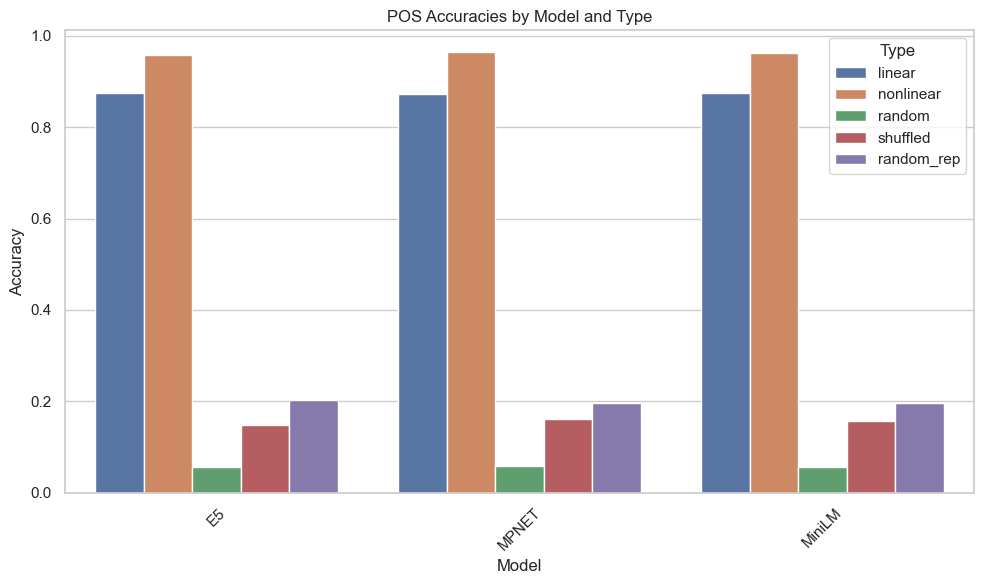

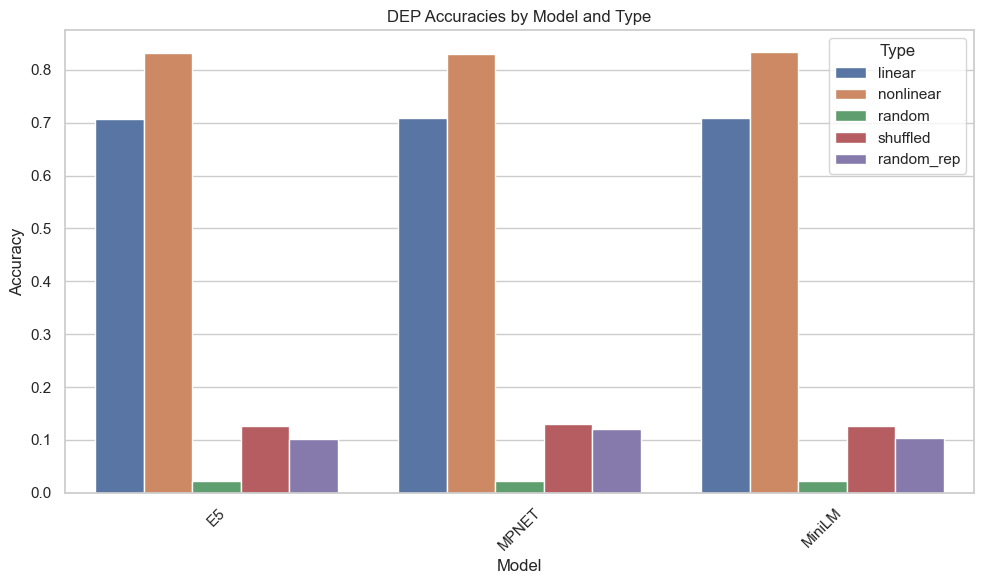

In [43]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Convert to DataFrame
records = []
for model, tagsets in eval_results.items():
    for tag, values in tagsets.items():
        for val_type, acc in values.items():
            records.append({'Model': model, 'Tag': tag, 'Type': val_type, 'Accuracy': acc})

df = pd.DataFrame.from_records(records)

# Set seaborn style
sns.set(style="whitegrid")

# Function to plot a grouped bar chart for POS or DEP
def plot_seaborn_bar(tag_type):
    plt.figure(figsize=(10, 6))
    subset = df[df['Tag'] == tag_type]
    ax = sns.barplot(data=subset, x='Model', y='Accuracy', hue='Type')
    ax.set_title(f'{tag_type} Accuracies by Model and Type')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# Plot POS and DEP
plot_seaborn_bar('POS')
plot_seaborn_bar('DEP')
